In [1]:
### ---- (1) ---- ####
#Import Python libraries
import os
import sys
sys.path.append('../PyScripts')
import xarray as xr
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import funcs
from datetime import datetime,timedelta
from scipy import signal, stats, ndimage
from scipy.signal import butter, lfilter, square, sawtooth, correlate
import nitime.algorithms as tsa
import multiprocessing
from joblib import Parallel,delayed
from sklearn.cluster import DBSCAN
num_cores = 16 #Set # cores for parallel executions
from skimage.measure import regionprops_table
import trackpy as tp
import pandas as pd
from matplotlib.lines import Line2D         
#Set format for datetime objects
fmt = '%Y%m%d_%H%M'

#Increase with of notebook to fill screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#Import plotting functions (for map with borders and states)
from cartopy.feature import NaturalEarthFeature,BORDERS,LAKES,COLORS
import cartopy.crs as crs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from metpy import calc
#Import colormaps
from metpy.plots import colortables
import colorcet as cc
import cmasher as cmr

#Retrieve perceptually uniform colorbar from colorcet
cmapp = cc.cm.rainbow_bgyrm_35_85_c71

#Set format for datetime objects
fmt = '%Y%m%d_%H%M'

# Download/add state and coastline features for cartopy 
states = NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")

land_50m = NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='k',
                                        facecolor='none')

#Define function to add map data to matplotlib plot
def add_map(ax,clr,lw):
    ax.add_feature(states)
    ax.add_feature(BORDERS)
    ax.add_feature(land_50m)
    ax.add_feature(states,edgecolor=clr,lw=lw)
    ax.add_feature(LAKES, edgecolor=clr)

#Define function to add latitude/longitude grid lines to cartopy/matplotlib plot
def add_gridlines(ax,xl,yl,clr, fs):
    gl = ax.gridlines(crs=crs.PlateCarree(), draw_labels=True,
                      linewidth=0.25, color=clr, alpha=1, linestyle='--')

    gl.xlabels_bottom = xl
    gl.xlabels_top = False
    gl.ylabels_left = yl
    gl.ylabels_right = False

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': fs, 'color': clr}
    gl.ylabel_style = {'size': fs, 'color': clr}
    return gl

#Get Composite Reflectivity colormap from metpy
ctable1 = 'NWSStormClearReflectivity'
cmapp = cc.cm.rainbow_bgyrm_35_85_c71
norm, cmapp_radar = colortables.get_with_steps(ctable1, 244, 244)

#Define function to mask pressure analyses over water
def mask_grid(arr):
    arr = np.ma.masked_where(landsea==0,arr)
    return arr

#Define function to read and subset a land/sea boolean grid
def get_landsea():
    ds_land = xr.open_dataset('../../data/Static/landsea.nc')
    ds_land = funcs.subset(ds_land,minLat,maxLat,minLng,maxLng)
    landsea = ds_land['LANDSEA'].values
    landsea = np.pad(landsea, ((0,1),(0,1)), 'edge')
    ds_land.close()
    return landsea

from itertools import combinations, product

def pairs(*lists):
        for t in combinations(lists, 2):
                for pair in product(*t):
                        #Don't output pairs containing duplicated elements
                        if pair[0] != pair[1]:
                                yield pair
                                
#Find unique points (i.e. locations) in perturbation tracks
def uniq_par(pp):
        npar = []
        #Simple lazy loop through list of coordinates to find unique points
        for i in range(0,len(pp)):
                for j in range(0,len(pp)):
                        if (pp[i] == pp[j]):
                                continue

                        pp1 = (pp[i],pp[j])
                        pp2 = pp1[::-1]
                        if ((pp1 in npar) or (pp2 in npar)):
                                continue
                        else:
                                npar.append(pp1)
        return npar

## Feature tracking functions ##

#Track positive pressure features in composite analyses
def get_track_pos(parr2):
    #Loop through contour levels (i.e. starting at 0.75 hPa) to label features
    #(Note that not all features may be have contours above the specified threshold at all times - recall tracking allows for feature to "disappear" for up to two frames)
    plimit = 0.75
    while (plimit > 0.25):
        #Label feature using pressure threshold 
        mask = parr2 >= plimit #im.mean()
        label_im, nb_labels = ndimage.label(mask)
        #Delabel any regions below threshold
        label_im[parr2<plimit] = 0

        #Get list of unique labels
        nlu = np.unique(label_im.flatten())
        nlu = nlu[1:] #Ignore first label (0) which is region below threshold
        cmx = []; cmy = []; ff = []; cd = []
    
        #Loop through all times in composite analysis and retrieve centroid
        for i in range(0,parr2.shape[0]):
            nlu = np.unique(label_im[i,:,:].flatten())
            nlu = nlu[1:] #Ignore first label (0)
            #If there are no labels at this pressure threshold continue to next time 
            if (len(nlu) < 1):
                continue

            #Retrieve properties of labeled region
            props = regionprops_table(label_im[i,:,:], parr2[i,:,:], properties=['centroid']) #,'area','mean_intensity'])
            df = pd.DataFrame(props)
            #Save centroid of labeled region (i.e. track point)
            for p in df.index:
                prp = df.iloc[p]
                cmy.append(prp['centroid-0'])
                cmx.append(prp['centroid-1'])
                cd.append(((prp['centroid-0']-24)**2  + (prp['centroid-1']-24)**2)**0.5)
                ff.append(i)

        #Create dataframe to store centroid points
        dft = pd.DataFrame(dict(x=cmx,y=cmy,frame=ff,cdist=cd)) #arange(,lat=coms_xlat,lng=coms_xlng))

        #If no tracks were found lower threshold until a track is retrieved
        if (len(dft) == 0):
            plimit = plimit-0.05
            continue

        #Retrieve trajectories from label centroid points
        tmax = 8; #Feature must be present for at least 8 frames
        tp.quiet(suppress=True)
        tr = tp.link_df(dft, 5, memory=2) #Allow feature centroid to drift up to five points and disappear for up to two frames
        tr1 = tp.filter_stubs(tr, tmax)

        #Group trajectories
        grouped = tr.groupby('particle')
        tr1 = grouped.filter(lambda x: x.frame.count() >= tmax,dropna=True)

        #If trajectory contains no points try to find tracks at lower pressure threshold
        tarr = tr1.to_xarray()
        if (len(tarr['particle'].values) < 1):
                plimit = plimit-0.05
                continue

        #Find label of trajectory passing through centroid during time-window
        tarr_max = tarr.groupby('particle').min()
        gpi = np.argmin(tarr_max['cdist'].values)
        gp = tarr_max['particle'].values[gpi]
        
        #Keep main trajectory (i.e. one for feature passing through centroid - recall that composite analysis is centered on the feature of interest)
        #However composite analysis can also include features on the periphery of the main pressure feature being composited
        trj = tarr.where(tarr.particle==gp,drop=True)
        return trj
        break
    
    
#Define bounding box for analysis
minLng = -97.5; maxLng = -88.5; minLat = 30; maxLat= 35
#Get land/sea boolean within bounding box
landsea = get_landsea()
landsea = landsea[:-1,:-1]

In [2]:
#File starts 2-days and 6-hours into the month (648 five-min periods)
i0 = 648 
#Retrieve MADIS feature tracks
ds_madis_track = xr.open_dataset('../../data/Cases/24hr_madis_positive_tracks.nc')
ds_madis_track['frame'].values = ds_madis_track['frame'].values+i0 #Correct frame number
#Get list of dates
s1 = '20180331_0000'
s2 = '20180501_0000'
dds = funcs.date_list(s1,s2,300,fmt)
dts2 = funcs.to_dt(dds,fmt)

#Retrieve smartphone feature tracks
ds_smart_track = xr.open_dataset('../../data/Cases/24hr_smart_positive_tracks.nc')
ds_smart_track['frame'].values = ds_smart_track['frame'].values+i0

#Retrieve perturbation analyses
dg2 = xr.open_dataset('../../data/Cases/72hr_positive_pert.nc')
dg2 = funcs.subset(dg2,minLat,maxLat,minLng,maxLng)

#Get list of analysis times 
dts = np.array([datetime.utcfromtimestamp(d) for d in dg2['Valid'].values/1e9])

#Retrieve mesoscale surface perturbations
alts_meso_smart = dg2['alts_smart'].values
alts_meso_madis = dg2['alts_madis'].values
temp_meso = dg2['temp'].values 
dwpt_meso = dg2['dwpt'].values 
uwnd_meso = dg2['uwnd'].values*1.94384449 #convert to kts
vwnd_meso = dg2['vwnd'].values*1.94384449 #convert to kts
lngs = dg2['longitude'].values
lats = dg2['latitude'].values

In [3]:
#Convert datetime objects to list of dates
dtlist = [datetime.strftime(d,fmt) for d in dts]

#Define dimensions of bounding box (in grid points)
yl = 50; xl = 50
#Define 2-D coordinate grid
X,Y = np.meshgrid(lngs,lats)

#Set domain limits (to ensure plot dimensions stay fixed)
mlat = 39; mlng = -78.25
yidx = np.argmin(abs(lats-mlat))
xidx = np.argmin(abs(lngs-mlng))

#Define function to plot/save pressure and composite reflectivity analysis 
def plot_box(d,ddate):

    #Get date and index (start when feature is just formed)
    d = d+161
    #(+24 hrs to ensure perturbations match track:  perturbation files start day before first of month whereas track files start on the first of the month)
    #This was done to ensure bandpass filtered perturbations on the first day of each month would not be affected by edge effects.
    di = dds.index(ddate)+288 
    
    fig = plt.figure(figsize=(20,6.5))
    #define projection for spatial plots
    axx1 = plt.subplot(121,projection=crs.PlateCarree())
    axx2 = plt.subplot(122) 
    
    #Set default fontsize for plot
    matplotlib.rcParams.update({'font.size': 18})
    
    #Define temporal range for time-series.
    minf = (d+288)-12*12
    maxf = (d+288)+12*12

    #Get 5-min reflectivity and altimeter analysis
    
    #Mask altimeter anlaysis over water
    alts_meso_2d_smart = mask_grid(alts_meso_smart[d+288])
    #Smooth altimeter analysis for contouring
    alts_meso_2d_smart_smooth = ndimage.gaussian_filter(alts_meso_smart[d+288],sigma=2.5)

    #Extract particle track for the squall-line case
    ds_tp = ds_smart_track.where(ds_smart_track.particle==182,drop=True)
    #Update the frame number by one day (perturbations are stored from last day of previous month while tracks are saved from first day of month)
    ts = ds_tp['frame'].values+288
    #Extract track coordinates (feature centroid) at date/time (ddate)
    ti = np.argwhere(ts==di).T[0][0]
    yc = ds_tp['lat'].values[ti+1]
    xc = ds_tp['lng'].values[ti+1]

    #Find the grid point closest to the feature centroid
    yi = np.argmin(abs(lats-yc))
    xi = np.argmin(abs(lngs-xc))
    #Define the borders of the 250 km x 250 km bounding box.
    y0,x0 = int(yi-(yl/2)),int(xi-(xl/2))
    yt,xt = int(yi+(yl/2)),int(xi+(xl/2))

    #Get indices that fall within bounding box and time-window.
    yidx = np.arange(y0,yt,1)
    xidx = np.arange(x0,xt,1)
    midx = np.arange(minf,maxf,1)

    #Set min/max value for perturbations
    mmin=-2
    mmax=2
    add_map(axx1,'dimgray',1) #Add States/borders
    levs = [-2,-1.5,-1.25,-1,-0.75,0.75,1,1.25,1.5,2]
    add_gridlines(axx1,True,True,'k',18) #Add grid lines and x/y labels  
    
    #Plot pressure perturbation analysis
    im = axx1.imshow(alts_meso_2d_smart,origin='lower',extent=[minLng,maxLng,minLat,maxLat],cmap=cmr.prinsenvlag_r,vmin=mmin,vmax=mmax)
    #Contour pressure every 1 hPa
    CS = axx1.contour(X,Y,mask_grid(alts_meso_2d_smart_smooth),levels=levs,colors='dimgrey',alpha=1)
    CS2 = axx1.contour(X,Y,mask_grid(alts_meso_2d_smart_smooth),levels=[0.75],colors='k',lw=2,alpha=1)    
    axx1.clabel(CS, CS.levels, inline=True, fmt="%1.2f", fontsize=14, colors='dimgrey') #Label contours
    #Set grid bounds
    axx1.set_xlim([minLng,maxLng])
    axx1.set_ylim([minLat,maxLat])
    axx1.axis('equal')
    axx1.set_title('Smartphone Perturbation Pressure (hPa)',fontsize=20)
        
    cb=plt.colorbar(im,ax=axx1,fraction=0.025) #Shrink colorbar to fit plot height
    cb.ax.set_title('($hPa$)',y=1.02,fontsize=18) #Set colorbar title
    cb.ax.tick_params(labelsize=18) #Set colorbar tick size

    #Plot centroid point
    ct = axx1.plot(xc,yc,'ok',ms=15,label='Centroid')
    #Plot feature track
    axx1.plot(ds_tp['lng'].values[:ti+1],ds_tp['lat'].values[:ti+1],'-k',lw=3,label='Track')
    #Add legend 
    handles, labels = axx1.get_legend_handles_labels()

    #Create custom patch for legend 
    margin = .1
    min_f0, max_f0 = lngs[xidx[0]], lngs[xidx[-1]]
    min_f1, max_f1 = lats[yidx[0]], lats[yidx[-1]]
    width = max_f0 - min_f0
    height = max_f1 - min_f1

    #Legend entry for bounding box
    pt = axx1.add_patch(
        patches.Rectangle(
            xy=(min_f0, min_f1),  # point of origin.
            width=width,
            height=height,
            linewidth=3,
            color='hotpink',
            fill=False
        )
    )
    #Add bounding box to legend
    pp = Line2D([0], [0], label = 'Bounding Box',color='hotpink',lw=3)
    handles.append(pp)
    
    #Plot legend
    axx1.legend(handles=handles,loc='upper center',fontsize=16,ncol=3)
    axx1.set_aspect('auto')

    #Plot time-series from MADIS and smartphone pressure perturbation analyses at feature centroids
    axx2.plot(dts[midx],alts_meso_smart[midx,yi,xi],'-k',color='orangered',lw=2,label='SMART Altimeter (hPa)')
    axx2.plot(dts[midx],temp_meso[midx,yi,xi],'-k',color='royalblue',lw=2,label='MADIS Temperature ($\degree$C)')

    #Plot title 
    axx2.set_title('Perturbation Time Series (at centroid point)',fontsize=20)
    axx2.axis('equal')
    #Set y-axis limits
    axx2.set_ylim([-3,3])
    axx2.grid(True)
    #Add label and legend
    axx2.set_ylabel('Perturbation Magnitude (hPa)')
    plt.legend(numpoints=1,loc='upper center',fontsize=16,ncol=2)
    #Rotate xticks for dates
    plt.xticks(rotation=45)
    axx2.set_xlim([dts[midx[0]],dts[midx[-1]]])
    axx2.set_aspect('auto')
    
    #Plot subplot title
    fig.canvas.draw()
    plt.tight_layout(w_pad=2.5)
    plt.subplots_adjust(top=0.85)
    plt.suptitle('Spatial (left) and Temporal (right) Perturbation Analysis: '+ddate[9:13]+' UTC '+ddate[4:6]+'/'+ddate[6:8]+'/'+ddate[0:4],fontsize=26)    

    #Set image number for ffmeg
    cnt = d-161
    if (cnt < 10):
        cs = '00'+str(cnt)
    elif ((cnt >= 10) and (cnt < 100)):
        cs = '0'+str(cnt)
    else:
        cs = str(cnt)
        
    #Save figure to file
    plt.savefig('../../Plots/surface_lang_analysis_'+cs+'.png')

In [ ]:
#Remove old pngs
os.system('rm -rf ../../Plots/surface_lang_analysis*')
#Create images for animation
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(plot_box)(d,ddate) for d,ddate in enumerate(dtlist[161:240]))

In [ ]:
#If animation (mp4 movie) already exists, remove it so ffmpeg won't ask to overwrite
if os.path.isfile('../../Plots/surface_lang_analysis.mp4'):
    os.system('rm -rf ../../Plots/surface_lang_analysis.mp4')
#Create mp4 movie from 5-min pressure perturbation / reflectivity anlayses saved as pngs
os.system('ffmpeg -r 6 -f image2 -s 1920x1080 -i ../../Plots/surface_lang_analysis_%03d.png -c:v libx264 -pix_fmt yuv420p ../../Plots/surface_lang_analysis.mp4')
#(Below) display video of positive perturbations

In [4]:
%%HTML
<div align="middle">
<video width="100%" controls>
      <source src = "../../Plots/surface_lang_analysis.mp4" type="video/mp4">
</video></div>

In [5]:
#Extract composite perturbation and composite track from case files
dss = xr.open_dataset('../../data/Cases/traj_smart_full_meso_stfull_mean_009.nc')
dss1 = xr.open_dataset('../../data/Cases/traj_smart_full_meso_stfull_track_009.nc')
dss2 = xr.open_dataset('../../data/Cases/composite_test.nc')
#Retrieve composite track location and time (convert location from grid point index to km)
trj = get_track_pos(dss['p_meso'].values[72:-72])
txx = trj['x'].values*5 - 125
tyy = trj['y'].values*5 - 125
tfrm = np.int32(trj['frame'].values)+72

In [6]:
#Demonstrate composite pressure analyses and tracking by highlighting spatial and temporal composites during the squall-line case.
def plot_comp(d):
  
    #Define limits for composite pressure perturbation analysis
    mmin=-2
    mmax=2
    levs = [-1.5,-1.25,-1,-0.75,-0.5,-0.25,0.25,0.5,0.75,1,1.25,1.5]

    fig = plt.figure(figsize=(20,6.5))
    matplotlib.rcParams.update({'font.size': 18})
    
    axx1 = plt.subplot(121)
    axx2 = plt.subplot(122) 
    
    #Retrieve composite track centroid at date/time d.
    ff = tfrm[d]
    tx = txx[d]
    ty = tyy[d]  

    #Plot pressure analysis
    p_meso_2d_smooth = ndimage.gaussian_filter(dss['p_meso'][ff,:,:].values,sigma=2.5)
    
    #Convert 2D meshgrid from grid indices to kilometers
    X2,Y2 = np.meshgrid(dss['x'].values*5 - 125,dss['y'].values*5 - 125)
    #Plot composite perturbation analyses at date/time d
    im = axx1.imshow(dss['p_meso'][ff].values,origin='lower',extent=[Y2.min(),Y2.max(),X2.min(),X2.max()],cmap=cmr.prinsenvlag_r,vmin=mmin,vmax=mmax)
    #Contour composite pressure perturbations
    CS = axx1.contour(X2,Y2,p_meso_2d_smooth,levels=levs,colors='dimgrey',alpha=1)
    CS1 = axx1.contour(X2,Y2,p_meso_2d_smooth,levels=[0.75],colors='k',linewidths=2,alpha=1)
    axx1.clabel(CS, CS.levels, inline=True, fmt="%1.2f", fontsize=14, colors='k') #Label contours
    #Set grid bounds
    axx1.set_xlim([X2.min(),X2.max()])
    axx1.set_ylim([Y2.min(),Y2.max()])
    ct = axx1.plot(txx[d+1],tyy[d+1],'ok',ms=15,label='Centroid')
    axx1.plot(txx[:d+1],tyy[:d+1],'-k',color='g',lw=3,label='Track')
    #Add axis labels and plot title
    axx1.grid(True)
    axx1.set_ylabel('(Y) N-S (km)')
    axx1.set_title('Composite Perturbation Pressure (T='+str((ff-144)*5)+' min)')
    axx1.set_xlabel('(X) E-W (km)') 
    #Create legend
    handles, labels = axx1.get_legend_handles_labels()
    #Add feature threshold contour to legend
    pp = Line2D([0], [0], label = 'Feature Threshold',color='k',lw=2)
    handles.append(pp)
    axx1.set_aspect('auto')
    axx1.legend(handles=handles,ncol=3,fontsize=15,loc='upper center')
    
    #Add colorbar
    cb=plt.colorbar(im,ax=axx1,fraction=0.025) #Shrink colorbar to fit plot height
    cb.ax.set_title('($hPa$)',y=1.02,fontsize=18) #Set colorbar title
    cb.ax.tick_params(labelsize=18) #Set colorbar tick size

    #Convert from km to no-dim grid index units
    tyi = int((ty+125)/5)
    txi = int((tx+125)/5)
    
    #Retrieve composite pressure and temperature time-series at date/time d
    dtt = (dss['Valid'].values-144)*5 #Adjust from time in min to frame.
    axx2.plot(dtt,dss['p_meso'][:,tyi,txi].values,'-k',color='orangered',lw=2,label='SMART Altimeter (hPa)')
    axx2.plot(dtt,dss['t_meso'][:,tyi,txi].values,'-k',color='royalblue',lw=2,label='MADIS Temperature ($\degree$C)')
    axx2.set_title('Composite Perturbation Time Series (X='+str(int(tx))+',Y='+str(int(ty))+')',fontsize=22)
    
    #Add title and axis labels
    axx2.set_ylim([-2,2])
    axx2.grid(True)
    axx2.set_xlabel('Time (minutes)')
    axx2.set_ylabel('Perturbation Magnitude')
    
    #Add legend above topmost plot.
    plt.legend(numpoints=1,ncol=1,fontsize=15,loc='upper right') 
    axx2.set_aspect('auto')
    axx2.set_xlim([dtt[0],dtt[-1]])

    #Add subplots title and adjust plot accordingly
    fig.canvas.draw()
    plt.tight_layout(w_pad=2.5)
    plt.subplots_adjust(top=0.85)
    plt.suptitle('Spatial (left) and Temporal (right) Composite Perturbation Analysis',fontsize=26)
    
    #Get image number for ffmpeg
    cnt = d
    if (cnt < 10):
        cs = '00'+str(cnt)
    elif ((cnt >= 10) and (cnt < 100)):
        cs = '0'+str(cnt)
    else:
        cs = str(cnt)
        
    #Save figure
    plt.savefig('../../Plots/surface_comp_analysis_'+cs+'.png')

In [ ]:
#Remove old images
os.system('rm -rf ../../Plots/surface_comp_analysis*')
#Generate images to create mp4
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(plot_comp)(d) for d in range(0,len(tfrm[:-1])))

In [ ]:
#If animation (mp4 movie) already exists, remove it so ffmpeg won't ask to overwrite
if os.path.isfile('../../Plots/surface_comp_analysis.mp4'):
    os.system('rm -rf ../../Plots/surface_comp_analysis.mp4')
#Create mp4 movie from 5-min pressure perturbation / reflectivity anlayses saved as pngs
os.system('ffmpeg -r 6 -f image2 -s 1920x1080 -i ../../Plots/surface_comp_analysis_%03d.png -c:v libx264 -pix_fmt yuv420p ../../Plots/surface_comp_analysis.mp4')
#(Below) display video of positive perturbations

In [7]:
%%HTML
<div align="middle">
<video width="100%" controls>
      <source src = "../../Plots/surface_comp_analysis.mp4" type="video/mp4">
</video></div>

In [8]:
### ---- (2) ---- ####

#Perform cross correlation between two N-D arrays
def xcr(arr1,arr2):
    arr1 = (arr1-arr1.mean())/(arr1.std()*len(arr1))
    arr2 = (arr2-arr2.mean())/arr2.std()
    xcor = signal.correlate(arr1,arr2,'same')
    return xcor

#Bandpass filter
lowcut = 1/(3600*6) #lower band
highcut = 1/(3600*2) #Upper band
fs = 1/300.0 #Sampling frequency
order = 5 #5th order filter

#Provide functions to bandpass filter an array
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low,high], btype = 'bandpass')
    return b, a

#Run frequency filtering
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

#Filter time-series
def filter_ts(pprime):
    meso = butter_bandpass_filter(pprime, lowcut, highcut, fs, order)
    return meso

#Bandpass filter time-series retrieved within a rectangular region (i.e. 3-d array)
def bpass(vvar):
    meso = np.zeros(vvar.shape)
    for i in range(0,vvar.shape[1]):
            for j in range(0,vvar.shape[2]):
                    vtmp = vvar[:,i,j]
                    barr = filter_ts(vtmp)
                    meso[:,i,j] = barr
    return meso

In [9]:
#Functions for lag analysis (method of determining direction and speed of pressure features)
#These approaches are outlined in Nappo (2013), Chapter 10.2.5-10.2.6 and first demonstrated by Rees and Mobbs (1988)
t2 = np.arange(-6*60,6*60,5) #12-h time window for compositing analysis (analysis every 5-min)
#Compute the time difference between peak correlation at select grid points
def avg_ang(cmax,dx,dy,st,et):
    #Initialize grid
    xs = np.arange(st,et,dx)
    ys = np.arange(st,et,dy)
    xd = []; ux = np.zeros((len(xs),len(ys))); vx = np.zeros((len(xs),len(ys))); xx2 = np.zeros((len(xs),len(ys))); yy2 = np.zeros((len(xs),len(ys)))
    for i,x in enumerate(xs):
            for j,y in enumerate(ys):
                    #Note correlation analysis can be performed at different scales (dx = 8 works well; produces results consistent with beamsteering) | dx*5 km (grid size) = 40km.    
                    #Since we have a gridded analysis we can "pick" our stations to be select grid points
                    
                    #(RHS Eq. 10.22-10.23; Nappo, 2013)
                    dfdx = cmax[y,x+dx]-cmax[y,x-dx] #Time difference between peak correlation (at 40 km east and + 40km west from point y,x)
                    dfdy = cmax[y+dy,x]-cmax[y-dy,x] #Time difference between peak correlation (at 40 km north and + 40km south from point y,x)

                    #Fill pre-defined grid with zonal and meridional correlation lag (i.e. time difference between peak correlation).
                    ux[i,j] = dfdx
                    vx[i,j] = dfdy

    return ux,vx,xs,ys

#Using lag-analysis derive tau in the meridional and zonal directions using Eq. 10.22-10.33 Nappo, 2013
#Note that tau is the time difference between sets of synthetic stations (ie. grid points) chosen along a north-south (meridional) and east-west (zonal) axis.
def get_uv(parr,dx,win=True,plott=False):
    
    #Compute auto-correlation of N-D mesoscale pressure perturbation array
    xcorr = signal.correlate(parr,parr,mode='same')
    
    #Retrieve index of maximum correlatoin along the record dimension.
    cmax = xcorr.argmax(axis=0)
    cmax0 = cmax.copy()

    #Perform lag analysis
    dy = dx
    u,v,xx2,yy2 = avg_ang(cmax,dx,dy,dx,50-dx)

    #mask array where peak lag difference is nill or above a specified threshold
    xx2 = np.array(xx2); yy2 = np.array(yy2)
    
    #threshold to remove excessively large peak correlation time differences
    u1 = np.ma.masked_where(abs(u)>35,u)
    v1 = np.ma.masked_where(abs(v)>35,v)
    u2 = np.ma.masked_where((u1==0) & (v1==0),u1)
    v2 = np.ma.masked_where((u1==0) & (v1==0),v1)

    #Compute the mean of peak time lags in the meridional and zonal direction
    um = np.mean(u2)
    vm = np.mean(v2)
    
    #Eq. 10.25 (Nappo, 2013)
    #Derive azimuth of phase propogation
    alpha= np.arctan2(-um,-vm) #Direction toward which feature is moving
    alpha_vec = np.arctan2(vm,um) #Direction toward which feature is coming from

    #Create grid 
    X,Y = np.meshgrid(np.arange(0,50),np.arange(0,50))

    #Initialize DBSCAN Unsupervied Clustering
    db = DBSCAN(eps=10,min_samples=10)

    #Convert peak corrrelation array to 1-D
    cs = cmax.flatten()
    #Convert grid array to 1-D
    XX = np.array([X.flatten(),Y.flatten(),cs]).T

    #Perform clustering
    db.fit(XX)
    #Save labels
    kml = db.labels_
    #Find mode of labels
    mcc = stats.mode(kml)[0][0]

    #Window max correlation analysis to the time of the mode cluster (prevents correlation analysis from being corrupted by previous features that may be included in composite analysis)
    gidx = np.argwhere(kml!=mcc)
    #Remove max cross correlation data outside this cluster (time) window.
    for v in gidx:
        #Get x,y index from array
        cx,cy = np.unravel_index(v,cmax.shape)
        cmax[cx,cy] = -100 #Set value to null

    #Mask peak cross correlation where values are below zero
    cmax = np.ma.masked_where(cmax<0,cmax)

    #Plot Lag Analysis Results (Time-series, DBSCAN analysis, and Cross Correlation Peak Lag)
    if (win):
            et = cmax.max()
            st = cmax.min()
            
            if (plott):
                fig1=plt.figure(figsize=(14,8))
                matplotlib.rcParams.update({'font.size': 16})
                #Show results for full time window (6-h)
                ax1=plt.subplot(121)
                plt.imshow(cmax0,origin='lower',interpolation='bilinear',cmap=plt.cm.jet,aspect='auto')
                plt.colorbar()
                ax1.set_title(r"Full Time Series $(\tau_{max})$")
                #Show results for localized time window (useful to narrow focus to feature of interest if multiple features are observed)
                ax2=plt.subplot(122)
                plt.imshow(cmax,origin='lower',interpolation='nearest',cmap=plt.cm.jet,aspect='auto')
                ax2.set_title(r"DBSCAN Localized $(\tau_{max})$")
                plt.colorbar()
                plt.tight_layout()
                plt.subplots_adjust(top=0.85)
                plt.suptitle(r"Cross Correlation Peak Lag: $(\tau_{max})$")
                plt.show()

            return st,et,cmax,u2,v2
    else:
            return cmax,xx2,yy2,u2,v2
        
#Interpolate lag analysis to grid and plot results
def grid_uv(xx2,yy2,u2,v2,dx,plott=False):
    dw = xr.Dataset()

    #Convert directional peak lag time differences into xarray data arrays
    dw['u'] = xr.DataArray(u2,coords={'x':xx2,'y':yy2},dims={'x','y'})
    dw['v'] = xr.DataArray(v2,coords={'x':xx2,'y':yy2},dims={'x','y'})

    #Fill NaNs for plotting
    dy = dx
    df = dw.to_dataframe()
    dfn = df.fillna(method='ffill')
    dfn = dfn.fillna(method='bfill')

    #Interpolate data to finer grid for plotting
    xnew = np.arange(xx2[0],xx2[-1],1) #xx2[0],xx2[-1]+1,1)
    ynew = np.arange(xx2[0],xx2[-1],1) #yy2[0],yy2[-1]+1,1)

    dww = dfn.to_xarray()
    dww = dww.interp(x=xnew,y=ynew)
    dww = dww.pad(x=(dx+1,dx+1),y=(dy+1,dy+1),mode='edge')

    unew = dww['u'].values
    vnew = dww['v'].values

    #Solve Eq. 10.22-10.33 (Nappo, 2013) for Slowness components (Sx and Sy)
    Sx = (unew*300)/(2*dx*5000)
    Sy = (vnew*300)/(2*dy*5000)

    #Eq. 10.25 (Nappo, 2013) - Sign flipped to indicate direction FROM which the feature is propogating 
    new_alpha = np.arctan2(-Sx,-Sy) 
    
    #Use slowness components to estimate phase speed
    ph_speed = 1.0/((Sx**2 + Sy**2)**0.5) #Eq. 10.24 (Nappo, 2013)
    
    if (plott):
        fig1 = plt.figure(figsize=(14,8))
        matplotlib.rcParams.update({'font.size': 16})
        #Plot slowness components
        ax1=plt.subplot(221)
        im=plt.imshow(Sx,aspect='auto',origin='lower',interpolation='nearest',cmap=plt.cm.viridis)
        plt.title('$S_x$ $(s/m)$')
        plt.grid(True)
        plt.colorbar(im)
        plt.subplot(222)
        im=plt.imshow(Sy,aspect='auto',origin='lower',interpolation='nearest',cmap=plt.cm.viridis)
        plt.title('$S_y$ $(s/m)$')
        plt.grid(True)
        plt.colorbar(im)
        plt.subplot(223)
        #Plot phase speed and angle
        im=plt.imshow(np.degrees(new_alpha),aspect='auto',origin='lower',interpolation='nearest',cmap=plt.cm.viridis)
        plt.title('Phase Angle (deg)')
        plt.grid(True)
        plt.colorbar(im)
        plt.subplot(224)
        im=plt.imshow(ph_speed,aspect='auto',origin='lower',interpolation='nearest',cmap=plt.cm.viridis)
        plt.title('Phase Speed (m/s)')
        plt.grid(True)
        plt.colorbar(im)
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.suptitle("Lag Analysis (Gridded)")
        plt.show()
        
    return unew,vnew,new_alpha,ph_speed,Sx,Sy

In [10]:
#Functions for beamsteering analysis (method of determining direction and speed of pressure features)
#These approaches are outlined in Nappo (2013), Chapter 10.2.7 and defined in Rees et al. (2000)
#Beamsteering was used by de Groot et al. (2017) to track gravity waves using point pressure data from the U.S. Array

#Perform beamsteering in parallel
def all_ang(xx,yy,acorr,npar):
    #Initialize slowness plane grid
    Svec = np.zeros((len(xx),len(yy),acorr.shape[1]))
    mcorm = Parallel(n_jobs=num_cores)(delayed(get_mcor)(xx,yy,acorr,npar,x) for x in range(0,len(xx)))
    #Fill correlation grid in slowness plane
    for x,m in enumerate(mcorm):
            Svec[x,:,:] = m
    return Svec

#Calcaulate correlation in the slowness plane
def get_mcor(kx,ly,acorr,npar,x):
    mmean = []
    #Loop through meridional grid points in the Slowness plane (parallelize in x-direction, loop in y direction)
    for y in range(0,len(ly)):
        mcor = 0
        #Loop through unique track locations
        for p,pa in enumerate(npar):
            
            #Get the x,y index of the current and following track point
            y0 = pa[0][0]; y1 = pa[1][0]
            x0 = pa[0][1]; x1 = pa[1][1]

            dxx = (x1-x0)*5e3
            dyy = (y1-y0)*5e3
            mcor+=acorr[p]*np.exp(complex(0,1)*kx[x]*dxx + complex(0,1)*ly[y]*dyy) #Retrieve cross-correlation time series between track points
            
        #Compute average cross-correlation among non-repeated pairs in the array.
        mcor = np.array(mcor)
        mmean.append(mcor) #np.sum(mcor)) #(Eq. 10.31; Nappo, 2013)
        
    mmean = np.array(mmean)
    return mmean

def run_ccsd(parr1,pa):
    dt=300
    y0 = pa[0][1]; y1 = pa[1][1]
    x0 = pa[0][0]; x1 = pa[1][0]
    p11 = parr1[:,y0,x0]; p22 = parr1[:,y1,x1]    
    f, fki, fkj, cij, ph, coh = mtem(p11,p22,dt)    
    return cij    

#Perform beamsteering
def bsteer(parr1,tx,ty):
    #Limit number of points in trajectory to speed calculation
    tlen = len(tx) #rj['x'].values)
    gskip = 1
    for k in range(1,tlen):
            ttmp = len(tx[::k])**2
            if (ttmp < 100):
                    gskip = k
                    break
                    
    txx = list(tx[::gskip])
    tyy = list(ty[::gskip])

    #Save location of points in 1d array
    pp = []
    for i in txx:
            for j in tyy:
                    pp.append((int(i),int(j)))

    #Find unique locations
    npar1 = uniq_par(pp)

    #Initialize dimensions of slowness plane (km-1)
    kx0 = np.arange(-0.1,0.1+0.001,0.001)/1e3
    ly0 = np.arange(-0.1,0.1+0.001,0.001)/1e3    

    
    #Compute array power spectrum (sum of cross-spectral power density between all pairs of pressure time-series along the feature track)
    acorr = []
    acorr = Parallel(n_jobs=num_cores)(delayed(run_ccsd)(parr1,pa) for pa in npar1)    
    #Compute cross-spectral density to retrieve frequency coordinate
    dt=300
    pa = npar1[0]
    y0 = pa[0][1]; y1 = pa[1][1]
    x0 = pa[0][0]; x1 = pa[1][0]
    p11 = parr1[:,y0,x0]; p22 = parr1[:,y1,x1]    
    f, fki, fkj, cij, ph, coh = mtem(p11,p22,dt)    
        
    acorr = np.array(acorr)
    #Retrieve the slowness vector
    Svec = all_ang(kx0,ly0,acorr,npar1)
    #Identify the peak normalized cross-spectral power density in the slowness domain
    midx = np.unravel_index(np.argmax(Svec),Svec.shape)
   
    #Extract the wavenumbers.
    kxmin = kx0[midx[0]]
    lymin = ly0[midx[1]]

    ''' 
    This is used in the actual data processing code but not for plotting, comment out below:
    
    #Repeat the beam-steering analysis but at higher resolution, using the best estimate of wavenumber from the first low resolution pass
    kx = np.arange(kxmin-0.025,kxmin+0.025,0.001)/1e3
    ly = np.arange(lymin-0.025,lymin+0.025,0.001)/1e3
    
    #Retrieve slowness vector
    Svec = all_ang(kx,ly,acorr,npar1)
    midx = np.unravel_index(np.argmax(Svec),Svec.shape)
    '''
    kx = kx0; ly=ly0 #Copy components since we're not doing high-resolution analysis (keep it simple for plotting)
    
    #Get components of slowness vector
    omg = f[midx[-1]]
    #s/km
    Sx = (kx[midx[0]]/(2*np.pi*omg)) #s/km
    Sy = (ly[midx[1]]/(2*np.pi*omg)) #s/km
    
    #Round to nearest hundredth
    #Compute phase speed and aziumuth of phase propagation
    cspeed = 1.0/(Sx**2 + Sy**2)**0.5 #Eq. 10.24 (Nappo, 2013)
    
    phi = np.arctan2(Sy,Sx) #Eq. 10.25 (Nappo, 2013) | direction from which feature is propagating
    return omg,phi,cspeed,Sx,Sy,Svec[:,:,midx[2]]

# Log-scaling
def dB(x, out=None):
        if out is None:
                return 10 * np.log10(x)
        else:
                np.log10(x, out)
                np.multiply(out, 10, out)

#Estimate CSD using multitaper approach
def mtem(i, j, dt):
        """
        multitaper estimation method
        Input:
        i      first time series
        j      second time series

        Output:
        fki    power spectral density i
        fkj    power spectral density j
        cij    cross-spectral density ij
        coh    coherence
        ph     phase spectrum between ij at input freq

        """
        #print('i size', i.shape)
        #print('j size', j.shape)

        # apply multi taper cross spectral density from nitime module
        f, pcsd_est = tsa.multi_taper_csd(np.vstack([i,j]), Fs=1/dt, low_bias=True, adaptive=True, sides='onesided')

        # output is MxMxN matrix, extract the psd and csd
        fki = pcsd_est.diagonal().T[0]
        fkj = pcsd_est.diagonal().T[1]
        cij = pcsd_est.diagonal(+1).T.ravel()

        # using complex argument of cxy extract phase component
        ph = np.angle(cij)

        # calculate coherence using csd and psd
        coh = np.abs(cij)**2 / (fki * fkj)

        return f, fki, fkj, cij, ph, coh
    
#Estimate phase uncertainty through a monte carlo approach
def mtem_unct(i_, j_, dt_, cf, mc_no=20):
        """
        Uncertainty function using Monte Carlo analysis
        Input:
        i_     timeseries i
        j_     timeseries j
        cf     coherence function between i and j
        mc_no  number of iterations default is 20, minimum is 3

        Output:
        phif   phase uncertainty bounded between 0 and pi
        """
        #print('iteration no is', mc_no)

        data = np.vstack([i_,j_])
        # number of iterations
        # flip coherence and horizontal stack
        cg = np.hstack((cf[:-1], np.flipud(cf[:-1])))

        # random time series fi
        mc_fi = np.random.standard_normal(size=(mc_no,len(data[0])))
        mc_fi = mc_fi / np.sum(abs(mc_fi),axis=1)[None].T

        # random time series fj
        mc_fj = np.random.standard_normal(size=(mc_no,len(data[0])))
        mc_fj = mc_fj / np.sum(abs(mc_fj),axis=1)[None].T

        # create semi random timeseries based on magnitude squared coherence
        # and inverse fourier transform for js
        js = np.real(np.fft.ifft(mc_fj * np.sqrt(1 - cg ** 2)))
        js_ = js + np.real(np.fft.ifft(mc_fi *cg))

        # inverse fourier transform for xs
        is_ = np.real(np.fft.ifft(mc_fi))

        # spectral analysis
        f_s, pcsd_est = tsa.multi_taper_csd(np.vstack([is_,js_]), Fs=1/dt_, low_bias=True, adaptive=True, sides='onesided')
        cijx = pcsd_est.diagonal(+int(is_.shape[0])).T
        phi = np.angle(cijx)

        # sort and average the highest uncertianties
        pl = int(round(0.99*mc_no)+1)
        phi = np.sort(phi,axis=0)
        phi = phi[((mc_no+1)-pl):pl]
        phi = np.array([phi[pl-2,:],-phi[pl-mc_no,:]])
        phi = phi.mean(axis=0)#
        phi = np.convolve(phi, np.array([1,1,1])/3)
        phif = phi[1:-1]
        return phif
    
#Retrieve the cross spectral density, magnitude squared coherence, and phase of two time series.
def get_csd(arr1,arr2):
        #set time step (5-min/300 seconds)
        dt = 300
        #Perform spectral analysis
        f, fki, fkj, cij, ph, coh = mtem(arr1,arr2,dt)
        #Compute phase uncertainty
        try:
                phif = mtem_unct(arr1,arr2,dt,coh, mc_no=10)
        except:
                phif = [0]*len(f)
                
        rad2time = ph/(2*np.pi*f)
        mtcl2time = phif/(2*np.pi*f)
        neg_time= np.where(rad2time<0)
        dur_cycl = (1/f)
        rad2time[neg_time] = rad2time[neg_time]+dur_cycl[neg_time]

        #Compute CSD
        csd = np.abs(cij)**2
        #Compute magnitude squared coherence
        coh = np.abs(coh)**2
        #Get time lag when CSD is maximized
        mlag = np.argmax(csd)
        return [csd,coh,ph,phif,rad2time,mlag,f]

In [11]:
#Calculate wave-normal wind components and wave-normal wind perturbations

#! Note that many features are not gravity waves so inside of using the wave-normal terminology of Koch and Golus (1988)
#! we refer to u* as the wave-normal wind. In this context the wave-normal wind is simply the component of the wind normal to the direction of feature propagation 

#Retrieve wave-normal wind using wind components and direction of propogation of pressure feature.
def get_unorm(uw,vw,u1,v1,wang):
    #Calculate wave-normal wind (u*)
    unorm_wind = []
    for i in range(0,uw.shape[0]):
        unorm_2d = -uw[i]*np.sin(wang)-vw[i]*np.cos(wang) #Eq. 1 (Koch and Golus, 1988)
        unorm_wind.append(unorm_2d)

    #Calculate wave-normal wind perturbation (u'*) from perturbation wind components
    unorm_meso = []
    for i in range(0,u1.shape[0]):
        unorm_2d = -u1[i]*np.sin(wang)-v1[i]*np.cos(wang) #Eq. 1 (Koch and Golus, 1988)
        unorm_meso.append(unorm_2d)

    unorm_meso = np.array(unorm_meso)
    unorm_wind = np.array(unorm_wind)
    
    #Band pass wave-normal wind (for comparison with simply appyling Eq.1 to perturbation wind components)
    #Note that in general bandpass filtering the wave-normal wind produces a wave-normal wind perturbation that 
    #is roughly equivalent to simply applying Eq.1 (Koch and Golus) to band pass filtered wind components.
    uprime = bpass(unorm_wind)
    ustar_prime = np.array(uprime)
    
    #Return wave-normal wind perturbations produced using both techniques (i.e. bandpass before/after calculating wave-normal wind)
    return ustar_prime,unorm_meso

In [12]:
#Retrieve 3D composite analyses of pressure, temperature, dew point, and wind component perturbations. 
p1 = dss['p_meso'].values
t1 = dss['t_meso'].values
d1 = dss['d_meso'].values
u1 = dss['u_meso'].values
v1 = dss['v_meso'].values
#Retrieve 3D composite analyses of zonal and meridional wind components.
uw = dss['u_wind'].values
vw = dss['v_wind'].values

#Window data to 6-h time window (-3h to +3h, centered at time feature passed through of composite)
parr = p1[72:-72].copy()

dx=8
#Perform lag analysis (retrieve lag times between sets of grid points)
st,et,cmax0,u2,v2 = get_uv(parr,dx,True,False) #Use full 6-h time window
cmax,xx2,yy2,u2,v2 = get_uv(parr[st:et],dx,False) #Use windowing 
ugrid,vgrid,alpha_2d,cspeed,Sx,Sy = grid_uv(xx2,yy2,u2,v2,dx) #Retrieve gridded estimates of phase speed/slowness components
#Retrieve wave-normal wind perturbation estimate from cross-correlation lag analysis
uprime,umprime = get_unorm(uw,vw,u1,v1,alpha_2d)

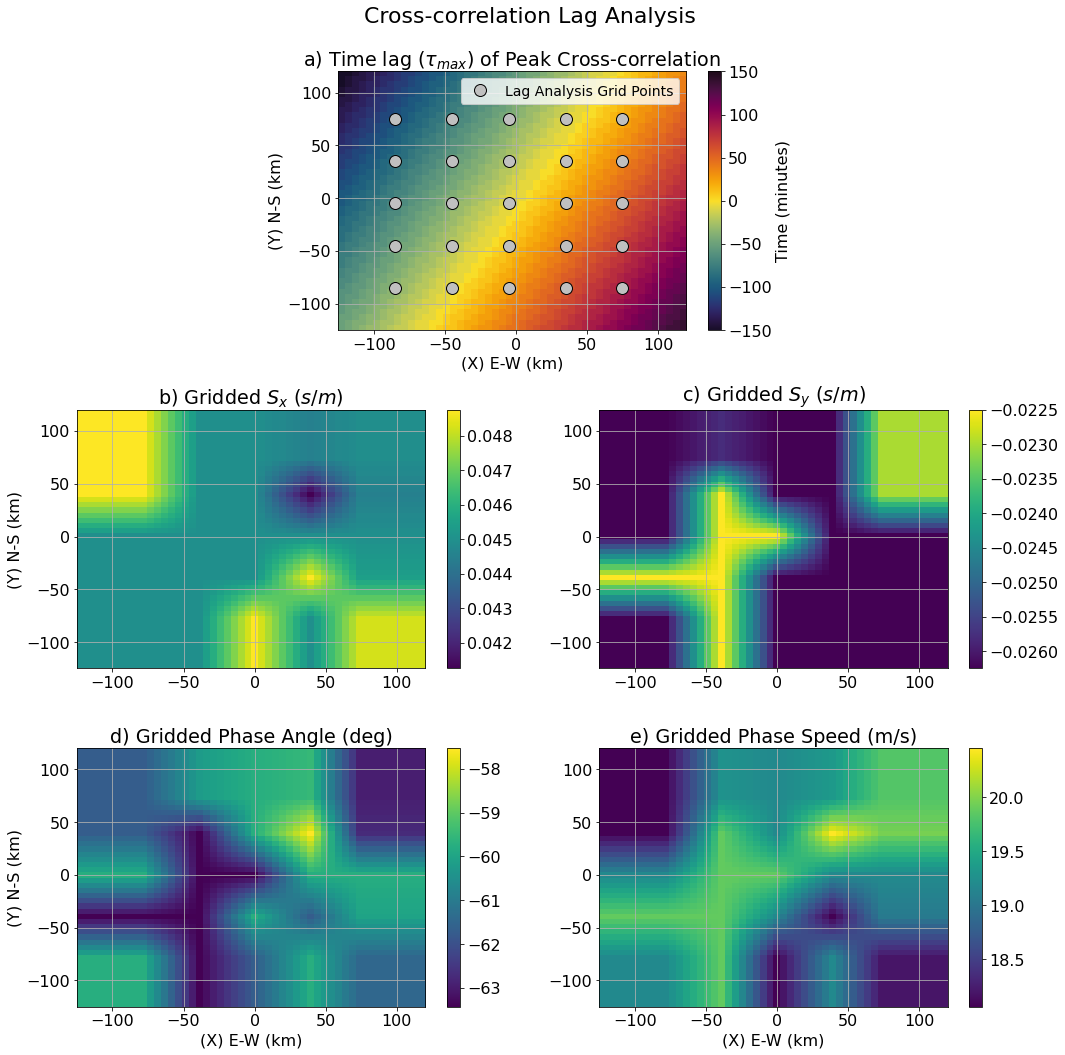

In [13]:
#Plot result of cross-correlation lag analysis
fig3 = plt.figure(figsize=(15,15))
X,Y = np.meshgrid(np.arange(-125,125),np.arange(-125,125))    
X2,Y2 = np.meshgrid(dss['x'].values*5 - 125,dss['y'].values*5 - 125)

gs = fig3.add_gridspec(3, 4)
matplotlib.rcParams.update({'font.size': 16})
ax1 = fig3.add_subplot(gs[0, 1:3])
#Show results for full time window (6-h)
im = ax1.imshow(((cmax+st)-72)*5,origin='lower',interpolation='nearest',cmap=cmr.pride,extent=[Y2.min(),Y2.max(),X2.min(),X2.max()],vmin=-150,vmax=150,aspect='auto')
for x in range(0,len(xx2)):
    for y in range(0,len(yy2)):
        if ((x == 0) and (y==0)):
            plt.plot(xx2[x]*5-125,yy2[y]*5-125,'ok',color='silver',markeredgecolor='k',ms=12,label='Lag Analysis Grid Points')
        else:
            plt.plot(xx2[x]*5-125,yy2[y]*5-125,'ok',color='silver',markeredgecolor='k',ms=12)


#Show distribution of (tau) difference in lag time (Nappo, 2013) across the 250 km x 250 km domain. Direction of feature motion is perpendicular to gradient.
ax1.set_title(r"a) Time lag $(\tau_{max})$ of Peak Cross-correlation")
ax1.legend(numpoints=1,loc='best',fontsize=14)
ax1.set_ylabel('(Y) N-S (km)')
ax1.set_xlabel('(X) E-W (km)')
ax1.grid(True)
cb = plt.colorbar(im,ax=ax1)
cb.ax.set_ylabel('Time (minutes)')                 
#Plot slowness components (Nappo, 2013)
ax2 = fig3.add_subplot(gs[1, 0:2])
im=plt.imshow(Sx,aspect='auto',origin='lower',interpolation='nearest',extent=[Y2.min(),Y2.max(),X2.min(),X2.max()], cmap=plt.cm.viridis)
ax2.set_title('b) Gridded $S_x$ $(s/m)$')
ax2.grid(True)
ax2.set_ylabel('(Y) N-S (km)')
cb = plt.colorbar(im,ax=ax2)
ax3 = fig3.add_subplot(gs[1, 2:])
im=ax3.imshow(Sy,aspect='auto',origin='lower',interpolation='nearest',extent=[Y2.min(),Y2.max(),X2.min(),X2.max()],cmap=plt.cm.viridis)
ax3.set_title('c) Gridded $S_y$ $(s/m)$')
ax3.grid(True)
cb = plt.colorbar(im,ax=ax3)
ax4 = fig3.add_subplot(gs[2, 0:2])
#Plot phase speed and angle (Nappo, 2013)
im=ax4.imshow(np.degrees(alpha_2d),aspect='auto',origin='lower',extent=[Y2.min(),Y2.max(),X2.min(),X2.max()],interpolation='nearest',cmap=plt.cm.viridis)
ax4.set_title('d) Gridded Phase Angle (deg)')
ax4.grid(True)
ax4.set_ylabel('(Y) N-S (km)')
ax4.set_xlabel('(X) E-W (km)')
cb = plt.colorbar(im,ax=ax4)
ax5 = fig3.add_subplot(gs[2, 2:])
im=plt.imshow(cspeed,aspect='auto',origin='lower',interpolation='nearest',extent=[Y2.min(),Y2.max(),X2.min(),X2.max()],cmap=plt.cm.viridis)
ax5.set_title('e) Gridded Phase Speed (m/s)')
ax5.set_xlabel('(X) E-W (km)')
ax5.grid(True)
cb = plt.colorbar(im,ax=ax5)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle("Cross-correlation Lag Analysis",fontsize=22)
plt.show()

In [14]:
um = np.mean(u2) 
vm = np.mean(v2)
vec_ccmean = np.arctan2(vm,um) #-um,-vm)

#Solve Eq. 10.22-10.33 (Nappo, 2013) for Slowness components (Sx and Sy)
Sx = (ugrid*300)/(2*dx*5000)
Sy = (vgrid*300)/(2*dx*5000)
vec_cc_2d = np.arctan2(Sy,Sx) #Eq. 10.25 (Nappo, 2013) - Sign flipped to indicate direction FROM which the feature is propogating 

dx=8; dy=dx; st=dx; et=50-dx
xss = np.arange(st,et,dx)
yss = np.arange(st,et,dy)
#Perform beamsteering of composite pressure time series, collected every 3rd time step along the feature track.
omg,alphab,cspeedb,Sxb,Syb,Svec = bsteer(p1,dss2['txx'].values[::3],dss2['tyy'].values[::3])
#Print beamsteering results
print(str(omg)+','+str(alphab)+','+str(cspeedb)+','+str(Sxb)+','+str(Syb))
#Retrieve wave-normal wind perturbation estimate from beamsteering analysis
uprimeb,umprimeb = get_unorm(uw,vw,u1,v1,alphab)
#Compute propagation direction from slowness components (i.e. direction toward which feature is propagating)
vec_bsteer = np.arctan2(-Syb,-Sxb) 
vec_bsteer = np.pi/2 - vec_bsteer

<ipython-input-10-bb27367b6853>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  Svec[x,:,:] = m


8.101851851851853e-05,-1.0370881351556307,19.920836694266228,0.025537547440116874,-0.043217387975581965


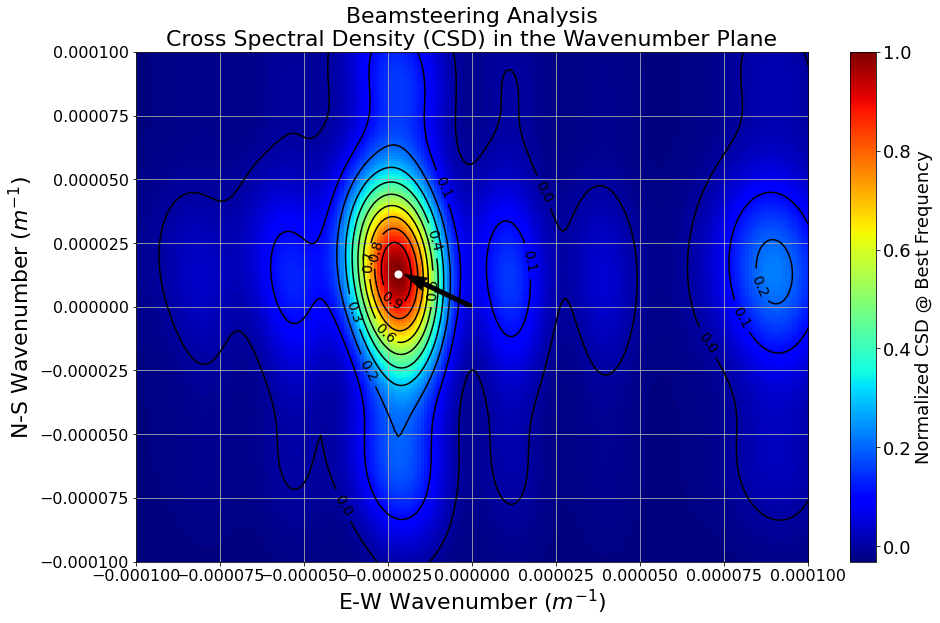

In [15]:
#Dimensions of slowness plane (s/m)
xx = np.arange(-0.1,0.1+0.001,0.001)/1e3
yy = np.arange(-0.1,0.1+0.001,0.001)/1e3 

#Plot Diagram depicting beamsteering (i.e. cross correlation in the slowness plane)
X1,Y1 = np.meshgrid(xx,yy)
fig = plt.figure(figsize=(14,9))
ax1 = plt.subplot(111)
matplotlib.rcParams.update({'font.size': 18})
im=plt.imshow(Svec/Svec.max(),origin='lower',aspect='auto',extent=[X1.min(),X1.max(),Y1.min(),Y1.max()],interpolation='nearest',cmap=plt.cm.jet) #,vmin=0,vmax=1) #levels=np.arange(0,1,0.05))
#Contour cross correlation in the slowness plane
CS = plt.contour(X1,Y1,Svec/Svec.max(),levels=np.arange(0,1,0.1),colors='k') #levels=np.arange(0,1,0.05))
ax1.clabel(CS, CS.levels, inline=True, fmt="%1.1f", fontsize=14, colors='k') #Label contours
#Identify centr of plane
plt.scatter(Syb*omg*2*np.pi,Sxb*omg*2*np.pi,c='w',s=50) #xx[midx[0]],yy[midx[1]],c='w',s=25)
#Plot slowness vector (points toward direction from which the feature is propagating)
plt.quiver(0, 0, Syb*omg*2*np.pi*1.05, Sxb*2*np.pi*omg*0.85,units='xy',scale=1)
#plt.arrow(0,0,Syb*omg*0.85,Sxb*omg*0.85,fc='black',ec='black',head_length=0.005,head_width=0.005)
#Add labels and titles
plt.ylabel('N-S Wavenumber $(m^{-1}$)',fontsize=22)
plt.xlabel('E-W Wavenumber $(m^{-1})$',fontsize=22)
plt.title('Beamsteering Analysis\nCross Spectral Density (CSD) in the Wavenumber Plane',fontsize=22)
cb=plt.colorbar(im)
cb.ax.set_ylabel('Normalized CSD @ Best Frequency')
plt.tight_layout()
plt.grid(True)
plt.show() #('PPlot_Tracks/'+month+'/'+sign+'/'+str(nmi)+'/Track_Analysis/bsteer.png')

Text(0.5, 0.98, 'Composite Perturbation Pressure and Wind Analysis at (T=0 min)')

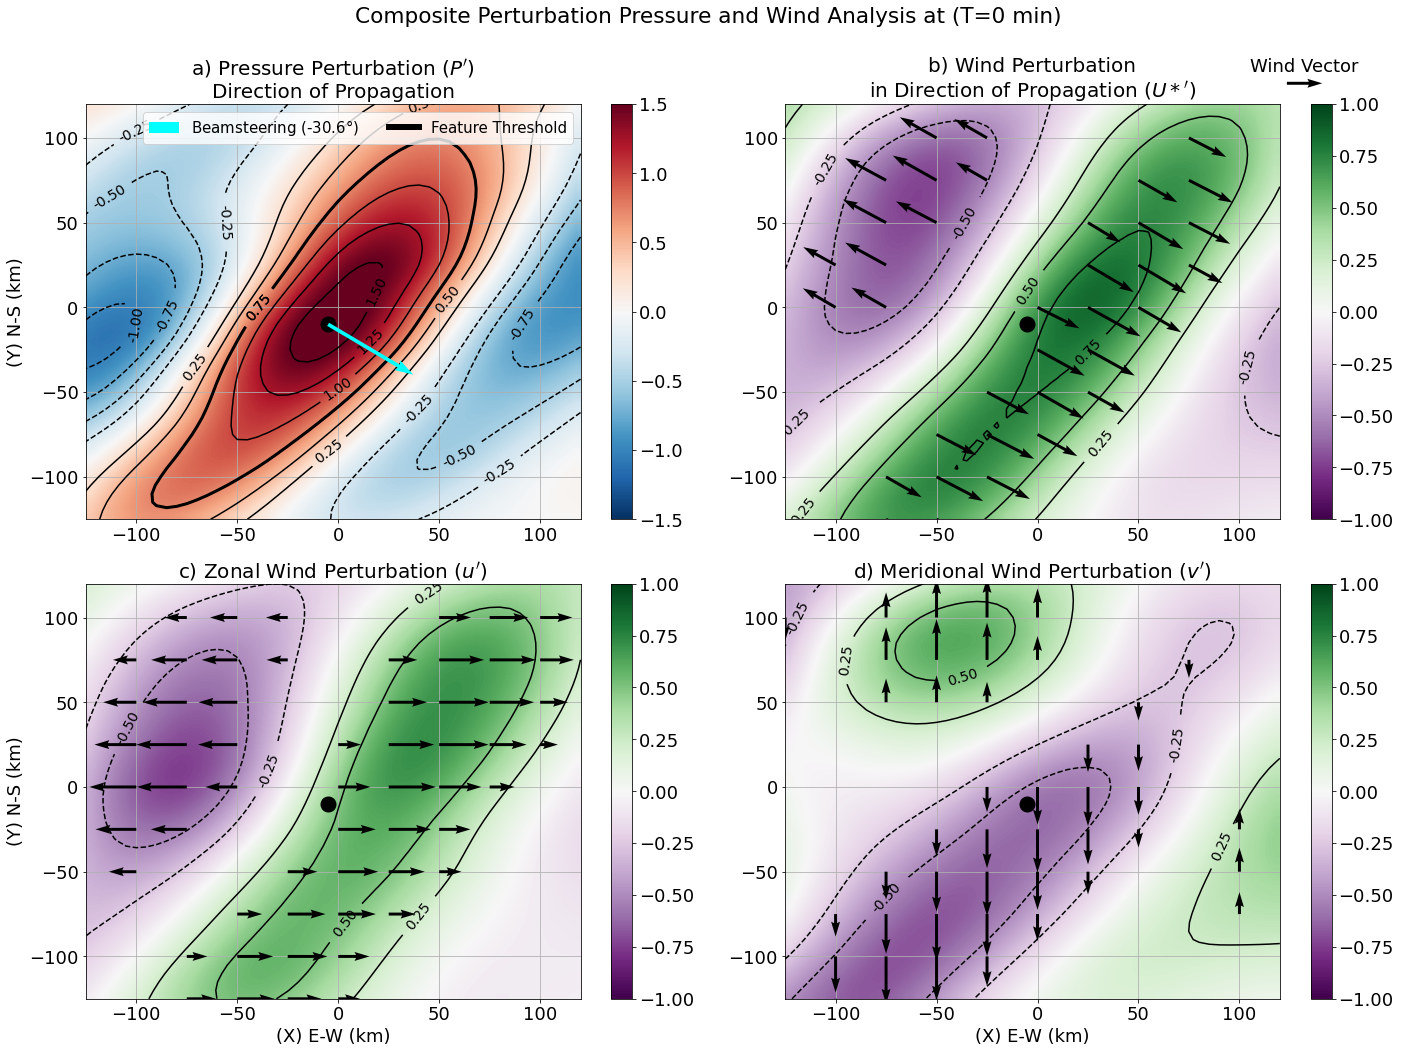

In [16]:
#Plot pressure and wind perturbations at the center of the composite time window (T=0)
frm = dss2['frame'].values-72
txx = dss2['txx'].values
tyy = dss2['tyy'].values
fi = np.argwhere(frm<=72).T[0]

#Define the origin (center of the domain)
origin = 5*np.float32([txx[fi][-1]])-125,5*np.float32([tyy[fi][-1]])-125
#Retrieve the direction of feature propagation (estimated from cross-correlation lag analysis, at the origin)
vec_ccenter = vec_cc_2d[txx[fi][-1],[tyy[fi][-1]]][0]

#Initialize figure
fig = plt.figure(figsize=(20,15))
ax1 = plt.subplot(221)

#Define 50x50 domain grid
X,Y = np.meshgrid(np.arange(0,50),np.arange(0,50))
#Display the composite pressure perturbation valid at the center of the time window
im = ax1.imshow(parr[72,:,:],origin='lower',aspect='auto',interpolation='bilinear',cmap=plt.cm.RdBu_r,extent=[Y2.min(),Y2.max(),X2.min(),X2.max()],vmin=-1.5,vmax=1.5)
#Plot a point at the origin
ax1.plot(txx[fi][-1]*5-125,tyy[fi][-1]*5-125,'ok',color='k',lw=3,ms=15)
#Add a title
ax1.set_title("a) Pressure Perturbation ($P'$)\nDirection of Propagation",fontsize=20)
#Define contour levels for pressure perturbations
levs = list(np.arange(-1.5,1.75,0.25))
levs.remove(0)

CS = ax1.contour(X2,Y2,parr[72,:,:],levels=levs,colors='k')
ax1.clabel(CS, CS.levels, inline=True, fmt="%1.2f", fontsize=14, colors='k') #Label contours
CS1 = ax1.contour(X2,Y2,parr[72,:,:],levels=[0.75],linewidths=3,colors='k')
ax1.clabel(CS1, CS1.levels, inline=True, fmt="%1.2f", fontsize=14, colors='k') #Label contour which defines feature boundary in bold (0.75 hPa)

#Plot direction of propagation (indicted by vector) for each analysis method (beamsteering and cross-correlation lag analysis)
q2 = ax1.quiver(*origin,10*np.cos(vec_bsteer),10*np.sin(vec_bsteer),scale=50,zorder=10,color='cyan',label='Beamsteering ('+str(round(np.degrees(vec_bsteer),1))+'$\degree$)')
#Define legend for contour lines
ax1.set_ylabel('(Y) N-S (km)',fontsize=18)
handles, labels = ax1.get_legend_handles_labels()
#pp = patches.Patch(color='hotpink', label='Bounding Box')
pp = Line2D([0], [0], label = 'Feature Threshold',color='k',lw=6)
handles.append(pp)
ax1.legend(handles=handles,ncol=2,loc='best',fontsize=15)
plt.colorbar(im)
plt.grid(True)

#Set number of spaces to grid points to skip when drawing wind vectors
dxx = 5
#Reduce density of wind vector components for feature-normal wind  (vectors should point in direction of propogation so swap sign)
up_skp = -uprimeb[144,::dxx,::dxx]*np.sin(alpha_2d[::dxx,::dxx])
vp_skp = -uprimeb[144,::dxx,::dxx]*np.cos(alpha_2d[::dxx,::dxx])

#plot the composite feature normal wind.
ax2 = plt.subplot(222)
im = ax2.imshow(uprimeb[144,:,:],origin='lower',aspect='auto',interpolation='bilinear',extent=[Y2.min(),Y2.max(),X2.min(),X2.max()],cmap=plt.cm.PRGn,vmin=-1,vmax=1)
plt.colorbar(im)
#Add origin point
ax2.plot(txx[fi][-1]*5-125,tyy[fi][-1]*5-125,'ok',color='k',lw=3,ms=15)
#Plot feature normal wind vectors
q2 = ax2.quiver(X2[::dxx,::dxx], Y2[::dxx,::dxx], np.ma.masked_where(abs(up_skp)<0.25,up_skp), np.ma.masked_where(abs(vp_skp)<0.25,vp_skp),scale=7,zorder=10,linewidths=0.5) #np.cos(alpha),10*np.sin(alpha),scale=50,zorder=10)
#Add key for wind vectors
qk = ax2.quiverkey(q2, 1.05, 1.05, 0.5, label="Wind Vector", labelpos='N', labelcolor='k')
ax2.set_title("b) Wind Perturbation\nin Direction of Propagation ($U*'$)",fontsize=20)
#Contour feature normal wind
CS = ax2.contour(X2,Y2,uprimeb[144,:,:],levels=levs,colors='k')
#Add contour labels
ax2.clabel(CS, CS.levels, inline=True, fmt="%1.2f", fontsize=14, colors='k') #Label contours
plt.grid(True)

#Plot perturbation wind components (zonal)
ax3 = plt.subplot(223)
im = ax3.imshow(u1[144,:,:],origin='lower',aspect='auto',interpolation='bilinear',extent=[Y2.min(),Y2.max(),X2.min(),X2.max()],cmap=plt.cm.PRGn,vmin=-1,vmax=1)
plt.colorbar(im)
#Plot perturbation wind vectors
q3 = ax3.quiver(X2[::dxx,::dxx], Y2[::dxx,::dxx], np.ma.masked_where(abs(u1[144,::dxx,::dxx])<0.25,u1[144,::dxx,::dxx]), v1[144,::dxx,::dxx]*0,scale=7,zorder=10,linewidths=0.5) #np.cos(alpha),10*np.sin(alpha),scale=50,zorder=10)
#Mark origin
ax3.plot(txx[fi][-1]*5-125,tyy[fi][-1]*5-125,'ok',color='k',lw=3,ms=15)
ax3.set_title("c) Zonal Wind Perturbation ($u'$)",fontsize=20)
#Contour wind perturbation magnitude
#Add contour labels
CS = ax3.contour(X2,Y2,u1[144,:,:],levels=levs,colors='k')
ax3.clabel(CS, CS.levels, inline=True, fmt="%1.2f", fontsize=14, colors='k') #Label contours
#Set axis labels
ax3.set_ylabel('(Y) N-S (km)',fontsize=18)
ax3.set_xlabel('(X) E-W (km)',fontsize=18)
plt.grid(True)

#Plot perturbation wind components (meridional)
ax4 = plt.subplot(224)
im = ax4.imshow(v1[144,:,:],origin='lower',aspect='auto',interpolation='bilinear',extent=[Y2.min(),Y2.max(),X2.min(),X2.max()],cmap=plt.cm.PRGn,vmin=-1,vmax=1)
plt.colorbar(im)
#Plot perturbation wind vectors
q4 = ax4.quiver(X2[::dxx,::dxx], Y2[::dxx,::dxx], u1[144,::dxx,::dxx]*0, np.ma.masked_where(abs(v1[144,::dxx,::dxx])<0.25,v1[144,::dxx,::dxx]),scale=7,zorder=10,linewidths=0.5) #np.cos(alpha),10*np.sin(alpha),scale=50,zorder=10)
#Mark origin
ax4.plot(txx[fi][-1]*5-125,tyy[fi][-1]*5-125,'ok',color='k',lw=3,ms=15)
ax4.set_title("d) Meridional Wind Perturbation ($v'$)",fontsize=20)
#Contour wind perturbation magnitude
CS = ax4.contour(X2,Y2,v1[144,:,:],levels=levs,colors='k')
#Add contour labels
ax4.set_xlabel('(X) E-W (km)',fontsize=18)
ax4.clabel(CS, CS.levels, inline=True, fmt="%1.2f", fontsize=14, colors='k') #Label contours

#ax1.legend(numpoints=1,ncol=3,loc='upper center',fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.subplots_adjust(top=0.89)
plt.suptitle("Composite Perturbation Pressure and Wind Analysis at (T=0 min)")

In [17]:
#Generate composite pressure and wind perturbation analyses for animation
def plot_wind(d):
        
    #Set first frame to zero, accounting for temporal windowing of data (we previously windowed the data from 288 frames to 144 frames recall: [72:-72])
    frm = dss2['frame'].values-72
    #Get composite feature track
    txx = dss2['txx'].values
    tyy = dss2['tyy'].values
    fi = np.argwhere(frm<=72).T[0]
   
    #Define the origin (center of the domain)
    origin = 5*np.float32([txx[d]])-125,5*np.float32([tyy[d]])-125

    #Compute time lag (T=0 being when the feature passes over the orgin)
    d
    d=d+frm[0]
    d0 = d-frm[0] #
    ff = str((d+72-144)*5) 
    
    #Set default plot font size
    matplotlib.rcParams.update({'font.size': 18})

    #Initialize figure
    fig = plt.figure(figsize=(20,15))
    ax1 = plt.subplot(221)
    #Define 50x50 domain grid
    X,Y = np.meshgrid(np.arange(0,50),np.arange(0,50))
    #Display the composite pressure perturbation valid at the center of the time window
    im = ax1.imshow(parr[d,:,:],origin='lower',aspect='auto',interpolation='bilinear',cmap=plt.cm.RdBu_r,extent=[Y2.min(),Y2.max(),X2.min(),X2.max()],vmin=-1.5,vmax=1.5)
    #Plot a point at the origin
    ax1.plot(txx[d0]*5-125,tyy[d0]*5-125,'ok',color='k',lw=3,ms=15)
    #Add a title
    ax1.set_title("a) Pressure Perturbation ($P'$)\nDirection of Propagation",fontsize=20)
    #Define contour levels for pressure perturbations
    levs = list(np.arange(-1.5,1.75,0.25))
    levs.remove(0)

    CS = ax1.contour(X2,Y2,parr[d,:,:],levels=levs,colors='k')
    ax1.clabel(CS, CS.levels, inline=True, fmt="%1.2f", fontsize=14, colors='k') #Label contours
    CS1 = ax1.contour(X2,Y2,parr[d,:,:],levels=[0.75],linewidths=3,colors='k')
    ax1.clabel(CS1, CS1.levels, inline=True, fmt="%1.2f", fontsize=14, colors='k') #Label contours
    #Plot direction of propagation (indicted by vector) derived from beamsteering analysis
    q2 = ax1.quiver(*origin,10*np.cos(vec_bsteer),10*np.sin(vec_bsteer),scale=50,zorder=10,color='cyan',label='Beamsteering ('+str(round(np.degrees(vec_bsteer),1))+'$\degree$)')
    ax1.set_ylabel('(Y) N-S (km)',fontsize=18)
    #Define legend for contour lines
    handles, labels = ax1.get_legend_handles_labels()
    pp = Line2D([0], [0], label = 'Feature Threshold',color='k',lw=6)
    handles.append(pp)
    ax1.legend(handles=handles,ncol=2,loc='best',fontsize=15)
    plt.colorbar(im)
    plt.grid(True)

    #Set number of spaces to grid points to skip when drawing wind vectors
    dxx = 5
    d = d+72
    #Reduce density of wind vector components for wave-normal wind  (vectors should point in direction of propogation so swap sign)
    up_skp = -uprimeb[d,::dxx,::dxx]*np.sin(alpha_2d[::dxx,::dxx])
    vp_skp = -uprimeb[d,::dxx,::dxx]*np.cos(alpha_2d[::dxx,::dxx])

    #plot the composite feature normal wind.
    ax2 = plt.subplot(222)
    im = ax2.imshow(uprimeb[d,:,:],origin='lower',aspect='auto',interpolation='bilinear',extent=[Y2.min(),Y2.max(),X2.min(),X2.max()],cmap=plt.cm.PRGn,vmin=-1,vmax=1)
    plt.colorbar(im)
    #Add origin point
    ax2.plot(txx[d0]*5-125,tyy[d0]*5-125,'ok',color='k',lw=3,ms=15)
    #Plot feature normal wind vectors
    q2 = ax2.quiver(X2[::dxx,::dxx], Y2[::dxx,::dxx], np.ma.masked_where(abs(up_skp)<0.25,up_skp), np.ma.masked_where(abs(vp_skp)<0.25,vp_skp),scale=7,zorder=10,linewidths=0.5) 
    #Add key for wind vectors
    qk = ax2.quiverkey(q2, 1.05, 1.05, 0.5, label="Wind Vector", labelpos='N', labelcolor='k')
    ax2.set_title("b) Wind Perturbation\nin Direction of Propagation ($u*'$)",fontsize=20)
    #Contour feature normal wind
    CS = ax2.contour(X2,Y2,uprimeb[d,:,:],levels=levs,colors='k')
    #Add contour labels
    ax2.clabel(CS, CS.levels, inline=True, fmt="%1.2f", fontsize=14, colors='k') #Label contours
    plt.grid(True)

    #Plot perturbation wind components (zonal)
    ax3 = plt.subplot(223)
    #Plot perturbation wind vectors
    im = ax3.imshow(u1[d,:,:],origin='lower',aspect='auto',interpolation='bilinear',extent=[Y2.min(),Y2.max(),X2.min(),X2.max()],cmap=plt.cm.PRGn,vmin=-1,vmax=1)
    plt.colorbar(im)
    q3 = ax3.quiver(X2[::dxx,::dxx], Y2[::dxx,::dxx], np.ma.masked_where(abs(u1[d,::dxx,::dxx])<0.25,u1[d,::dxx,::dxx]), v1[d,::dxx,::dxx]*0,scale=7,zorder=10,linewidths=0.5) 
    #Mark origin
    ax3.plot(txx[d0]*5-125,tyy[d0]*5-125,'ok',color='k',lw=3,ms=15) 
    ax3.set_title("c) Zonal Wind Perturbation ($u'$)",fontsize=20)
    #Contour wind perturbation magnitude
    #Add contour labels
    CS = ax3.contour(X2,Y2,u1[d,:,:],levels=levs,colors='k')
    ax3.clabel(CS, CS.levels, inline=True, fmt="%1.2f", fontsize=14, colors='k') #Label contours
    ax3.set_ylabel('(Y) N-S (km)',fontsize=18)
    ax3.set_xlabel('(X) E-W (km)',fontsize=18)
    plt.grid(True)

    #Plot perturbation wind components (meridional)
    ax4 = plt.subplot(224)
    im = ax4.imshow(v1[d,:,:],origin='lower',aspect='auto',interpolation='bilinear',extent=[Y2.min(),Y2.max(),X2.min(),X2.max()],cmap=plt.cm.PRGn,vmin=-1,vmax=1)
    plt.colorbar(im)
    #Plot perturbation wind vectors
    q4 = ax4.quiver(X2[::dxx,::dxx], Y2[::dxx,::dxx], u1[d,::dxx,::dxx]*0, np.ma.masked_where(abs(v1[d,::dxx,::dxx])<0.25,v1[d,::dxx,::dxx]),scale=7,zorder=10,linewidths=0.5) 
    #Mark origin
    ax4.plot(txx[d0]*5-125,tyy[d0]*5-125,'ok',color='k',lw=3,ms=15)
    ax4.set_title("d) Meridional Wind Perturbation ($v'$)",fontsize=20)
    #Contour wind perturbation magnitude
    CS = ax4.contour(X2,Y2,v1[d,:,:],levels=levs,colors='k')
    #Add contour labels
    ax4.set_xlabel('(X) E-W (km)',fontsize=18)
    ax4.clabel(CS, CS.levels, inline=True, fmt="%1.2f", fontsize=14, colors='k') #Label contours

    #Plot subplot title
    plt.grid(True)
    plt.tight_layout()
    plt.subplots_adjust(top=0.89)
    plt.suptitle("Composite Perturbation Pressure and Wind Analysis at (T="+str(ff)+" min)",fontsize=26)

    #Get image number
    cnt = d-72-frm[0]
    if (cnt < 10):
        cs = '00'+str(cnt)
    elif ((cnt >= 10) and (cnt < 100)):
        cs = '0'+str(cnt)
    else:
        cs = str(cnt)

    #Svae image
    plt.savefig('../../Plots/surface_wind_analysis_'+cs+'.png')

In [ ]:
#Remove old pngs
os.system('rm -rf ../../Plots/surface_wind_analysis*')
#Generate composite wind/pressure perturbation analyses plots for animation
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(plot_wind)(d) for d in range(0,len(tfrm[:-2])))

In [ ]:
#If animation (mp4 movie) already exists, remove it so ffmpeg won't ask to overwrite
if os.path.isfile('../../Plots/surface_wind_analysis.mp4'):
    os.system('rm -rf ../../Plots/surface_wind_analysis.mp4')
#Create mp4 movie from 5-min pressure perturbation / reflectivity anlayses saved as pngs
os.system('ffmpeg -r 6 -f image2 -s 1920x1080 -i ../../Plots/surface_wind_analysis_%03d.png -c:v libx264 -pix_fmt yuv420p ../../Plots/surface_wind_analysis.mp4')
#(Below) display video of positive perturbations

In [18]:
%%HTML
<div align="middle">
<video width="100%" controls>
      <source src = "../../Plots/surface_wind_analysis.mp4" type="video/mp4">
</video></div>

In [19]:
#Perform cross-spectral analysis of time-series at adjacent points along the composite feature track
def get_phase(arr):
        ccoh = []; lag = []; phi = []
        py1 = 0; px1 = 0
        for t in range(0,len(txx)):
                try:
                    #Retrieve the CSD, Magnitude squared coherence, phase, and lag data
                    cross_power,coherence,phase,phase_uncert,tlag,max_lag,freq = get_csd(p1[:,tyy[t],txx[t]],arr[:,tyy[t],txx[t]])
                    ccoh.append(coherence[max_lag]) #Retrieve the coherence
                    lag.append(tlag[max_lag]) #Retrieve the time-lag when CSD is maximized 
                    pm = phase[max_lag] #Get the phase at this time-lag
                    #Sum sin/cos of phase to compute average phase
                    py1 += np.sin(pm)
                    px1 += np.cos(pm)
                except:
                        pass
        #Compute average phase
        phi = np.arctan2(py1,px1)
        #Get list of coherence and max lags
        ccoh = np.array(ccoh)
        lag = np.array(lag)
        #Return the average coherence, max-lag, and phase of time-series retrieved along the composite feature track
        return [np.mean(ccoh),np.mean(lag),np.mean(phi)]


#Perform phase analysis for feature normal wind, temperature, and dew point perturbations
ccoh_wind,lag_wind,phi_wind = get_phase(uprimeb)
ccoh_temp,lag_temp,phi_temp = get_phase(t1)
ccoh_dwpt,lag_dwpt,phi_dwpt = get_phase(d1)

<ipython-input-10-bb27367b6853>:228: RuntimeWarning: invalid value encountered in true_divide
  rad2time = ph/(2*np.pi*f)
<ipython-input-10-bb27367b6853>:229: RuntimeWarning: divide by zero encountered in true_divide
  mtcl2time = phif/(2*np.pi*f)
<ipython-input-10-bb27367b6853>:231: RuntimeWarning: divide by zero encountered in true_divide
  dur_cycl = (1/f)
<ipython-input-10-bb27367b6853>:228: RuntimeWarning: divide by zero encountered in true_divide
  rad2time = ph/(2*np.pi*f)


/home/disk/p/cmcnich/miniconda3/envs/meteo_env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0.98, 'Spectral Analysis of Peturbation Pressure and Feature Normal Wind at (X=0,Y=0)')

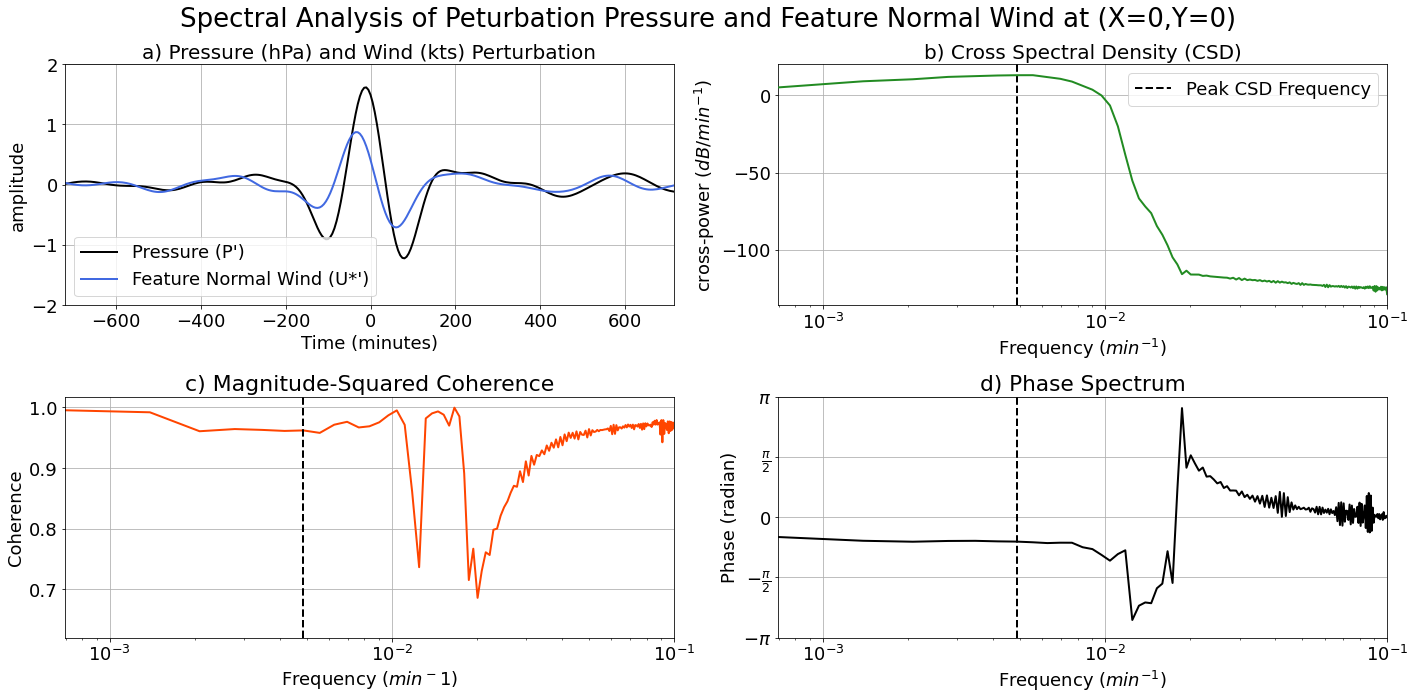

In [20]:
#Initialize Figure
plt.figure(figsize=(20,10))
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

#Retrieve composite pressure time-series at center of 50 x 50 grid domain
arr1 = p1[:,tyy[24],txx[24]]
#Retrieve composite feature normal wind time-series at center of 50 x 50 grid domain
arr2 = uprimeb[:,tyy[24],txx[24]]
#Time in minutes centred around time at which p' perturbation passes through the origin (center of domain)
tt = np.arange(-144,144,1)*5 

#time step is in minutes
dt = 5 
#Perform cross spectralk analysis between pressure and feature normal wind time-series retrieved from the center of the composite domain
f, fki, fkj, cij, ph, coh = mtem(arr1,arr2,dt)
phif = mtem_unct(arr1,arr2,dt,coh,mc_no=20) #Compute the phase uncertainty using a monte carlo approach
csd = np.abs(cij)**2 #Compute cross spectral density (CSD)
mlag = 7 #Lag of peak CSD

# plot composite time series of pressure and feature normal wind perturbations
ax1 = host_subplot(221)
ax1.grid(True)
#Define time-lags for abssica 
tt = np.arange(-144,144,1)*5
#Plot time-series
pp1, = ax1.plot(tt,arr1, 'k-', color='k',lw=2, label="Pressure (P')")
pp2, = ax1.plot(tt,arr2, 'k', color='royalblue', lw=2, label="Feature Normal Wind (U*')")
#Add axis labels and title
ax1.set_ylabel('amplitude')
ax1.set_xlabel('Time (minutes)')
ax1.set_title('a) Pressure (hPa) and Wind (kts) Perturbation',fontsize=20)
#Add legend and set axis limits
lg = plt.legend(numpoints=1,loc='best')
ax1.set_ylim([-2,2])
ax1.set_xlim([tt.min(),tt.max()])

# plot CSD
ax2 = plt.subplot(222)
#ax2.set_title('t (hours)', loc='left', fontsize=14)
ax2.set_title('b) Cross Spectral Density (CSD)',fontsize=20)
ax2.grid(True)
#Scale graph using 10 log 10 (dB) for cross-spectral power
ax2.plot(f,dB(cij), '-k', color='forestgreen', lw=2, zorder=4)
ax2.set_ylabel('cross-power ($dB/min^{-1}$)') # regex: ($10log10$)
ax2.set_xlabel(r'Frequency ($min^{-1}$)')
#Add vertical line at lag of peak CSD
ax2.axvline(x=f[mlag],color='k',linestyle='--',lw=2,label='Peak CSD Frequency')
plt.legend(numpoints=1,loc='best')
ax2.set_xlim([f[1],f.max()])
ax2.set_xscale('log')

# plot magnitude squared coherence
ax3 = plt.subplot(223)
#ax.set_xlim([xlim_start,xlim_end])
ax3.set_xlabel(r'Frequency ($min^-1$)')
ax3.set_ylabel('Coherence')
ax3.set_title('c) Magnitude-Squared Coherence',fontsize=22)
ax3.grid(True)
ax3.plot(f,np.real(coh), '-k',color='orangered',lw=2)
#Add vertical line at lag of peak CSD
ax3.axvline(x=f[mlag],color='k',linestyle='--',lw=2)
ax3.set_xlim([f[1],f.max()])
ax3.set_xscale('log')

#plot phase spectrum + uncertainty
ax4 = plt.subplot(224)
#Set y-axis ticks and labels
ax4.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax4.set_yticklabels(['$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
ax4.set_title('d) Phase Spectrum')
ax4.grid(True)
#Add axis labels and limits
ax4.set_ylim(-np.pi,np.pi)
ax4.set_ylabel('Phase (radian)')
ax4.set_xlabel(r'Frequency ($min^{-1}$)')
#Plot phase
ax4.plot(f,ph, 'k',lw=2)
ax4.set_xlim([f[1],f.max()])
ax4.set_xscale('log')

#Add vertical line at lag of peak CSD
ax4.axvline(x=f[mlag],color='k',linestyle='--',lw=2)
#Show phase uncertainty in filled color (for this case there is virtually none unless a high-pass filter, instead of band pass filter, is applied to wind normal data)
#plt.fill_between(f,ph,(ph-phif),facecolor='mediumturquoise' ,edgecolor='mediumturquoise',lw=0.0)#, where=(ph-phif)>=-np.pi)
#plt.fill_between(f,ph,(ph+phif),facecolor='mediumturquoise' ,edgecolor='mediumturquoise', lw=0.0)
#plt.fill_between(f,(ph+2*np.pi),((ph+2*np.pi)-phif), where=(ph-phif)<=-np.pi,
#                 facecolor='mediumturquoise' ,edgecolor='mediumturquoise', lw=0.0)
#plt.fill_between(f,(ph-2*np.pi),((ph-2*np.pi)+phif), where=(ph+phif)>=np.pi,
#                 facecolor='mediumturquoise' ,edgecolor='mediumturquoise', lw=0.0)
#ax4.set_xlim([f.min(),f.max()])

#Add subplot title
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Spectral Analysis of Peturbation Pressure and Feature Normal Wind at (X=0,Y=0)",fontsize=26)